In [26]:
# ==========================================
# 📦 Import Libraries
# ==========================================

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from time import time
import warnings
warnings.filterwarnings('ignore')

# Imbalance handling libraries (ทุกเทคนิค)
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

print("✅ Libraries imported!")

✅ Libraries imported!


In [27]:
# ==========================================
# 📥 1. Load Data
# ==========================================

print("\n" + "="*80)
print("📥 Loading Data")
print("="*80)

path = './Data/'
X_train_full = pd.read_csv(f'{path}X_train_90.csv')
y_train = pd.read_csv(f'{path}y_train_90.csv').squeeze()
X_test_full = pd.read_csv(f'{path}X_test_10.csv')
y_test = pd.read_csv(f'{path}y_test_10.csv').squeeze()

# Load selected features
selected_features = joblib.load('models/rfe_best_features.pkl')
X_train = X_train_full[selected_features]
X_test = X_test_full[selected_features]

print(f"✅ Data loaded:  {X_train.shape}")

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass distribution:")
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_train)*100:.1f}%)")

# Custom combined techniques
class AdasynTomek:
    """ADASYN + Tomek Links"""
    def __init__(self, random_state=42):
        self.adasyn = ADASYN(random_state=random_state)
        self.tomek = TomekLinks()
    
    def fit_resample(self, X, y):
        X_res, y_res = self.adasyn.fit_resample(X, y)
        X_res, y_res = self.tomek.fit_resample(X_res, y_res)
        return X_res, y_res

class BorderlineTomek:
    """Borderline SMOTE + Tomek Links"""
    def __init__(self, random_state=42):
        self.borderline = BorderlineSMOTE(random_state=random_state, kind='borderline-2')
        self.tomek = TomekLinks()
    
    def fit_resample(self, X, y):
        X_res, y_res = self.borderline.fit_resample(X, y)
        X_res, y_res = self.tomek.fit_resample(X_res, y_res)
        return X_res, y_res



📥 Loading Data
✅ Data loaded:  (9000, 10)

Class distribution:
  Class 0: 7200 (80.0%)
  Class 1: 1800 (20.0%)


In [28]:
# ==========================================
# 🎯 2. Define All 9 Imbalance Techniques
# ==========================================

print("\n" + "="*80)
print("🎯 Testing All Imbalance Techniques (5-Fold CV)")
print("="*80)

# ทุกเทคนิคที่ต้องการทดสอบ
sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'NearMiss': NearMiss(version=2),
    'ClusterCentroids': ClusterCentroids(random_state=42),
    'ADASYN+Tomek': AdasynTomek(random_state=42),
    'Borderline+Tomek': BorderlineTomek(random_state=42)
}

print(f"\n✅ Total techniques: {len(sampling_strategies)}")
print("\nTechniques:")
for idx, name in enumerate(sampling_strategies.keys(), 1):
    print(f"  {idx}. {name}")


🎯 Testing All Imbalance Techniques (5-Fold CV)

✅ Total techniques: 9

Techniques:
  1. SMOTE
  2. ADASYN
  3. RandomUnderSampler
  4. SMOTETomek
  5. SMOTEENN
  6. NearMiss
  7. ClusterCentroids
  8. ADASYN+Tomek
  9. Borderline+Tomek


In [29]:
# ==========================================
# 🎯 3. Simplified Parameters (เร็วขึ้น)
# ==========================================

# ลดจำนวน parameters
dt_params = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt_params_pipeline = {f'classifier__{k}': v for k, v in dt_params.items()}

print(f"\n✅ Simplified parameters for speed")


✅ Simplified parameters for speed


In [30]:
# ==========================================
# 🔍 4. Training with 5-Fold CV
# ==========================================

print("\n" + "="*80)
print("🔍 Random Search with 5-Fold CV (30 iterations each)")
print("="*80)

all_results = []
all_models = {}

# 5-Fold Stratified CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for idx, (technique_name, sampler) in enumerate(sampling_strategies.items(), 1):
    print(f"\n[{idx}/{len(sampling_strategies)}] {technique_name}...", end=' ')
    
    start_time = time()
    
    try:
        # Create pipeline with sampler
        model = ImbPipeline([
            ('sampler', sampler),
            ('classifier', DecisionTreeClassifier(random_state=42))
        ])
        params = dt_params_pipeline
        
        # Random Search with 5-Fold CV
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=30,  # 30 iterations
            scoring='balanced_accuracy',  # Better for imbalanced data
            cv=cv_strategy,
            n_jobs=-1,
            random_state=42,
            verbose=0,
            return_train_score=True
        )
        
        search.fit(X_train, y_train)
        
        # Predictions
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        from sklearn.metrics import balanced_accuracy_score
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        result = {
            'technique': technique_name,
            'cv_balanced_accuracy': search.best_score_,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'test_precision': precision_score(y_test, y_pred, zero_division=0),
            'test_recall': recall_score(y_test, y_pred, zero_division=0),
            'test_f1': f1_score(y_test, y_pred, zero_division=0),
            'test_roc_auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'time_seconds': time() - start_time,
            'best_fold_score': search.best_score_
        }
        
        all_results.append(result)
        all_models[technique_name] = best_model
        
        print(f"✅ Balanced Acc: {result['test_balanced_accuracy']:.4f} | "
              f"ROC-AUC: {result['test_roc_auc']:.4f} ({result['time_seconds']:.1f}s)")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")


🔍 Random Search with 5-Fold CV (30 iterations each)

[1/9] SMOTE... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.4994 | ROC-AUC: 0.5067 (10.6s)

[2/9] ADASYN... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.5075 | ROC-AUC: 0.5051 (9.3s)

[3/9] RandomUnderSampler... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tanana

✅ Balanced Acc: 0.5137 | ROC-AUC: 0.5109 (1.3s)

[4/9] SMOTETomek... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.4969 | ROC-AUC: 0.4817 (17.8s)

[5/9] SMOTEENN... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.4988 | ROC-AUC: 0.4763 (24.1s)

[6/9] NearMiss... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.4956 | ROC-AUC: 0.5129 (41.7s)

[7/9] ClusterCentroids... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.5594 | ROC-AUC: 0.5548 (45.8s)

[8/9] ADASYN+Tomek... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.5088 | ROC-AUC: 0.5081 (19.3s)

[9/9] Borderline+Tomek... 

/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/feature selection RF/Hyperparameter Tuning/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is depre

✅ Balanced Acc: 0.5125 | ROC-AUC: 0.5122 (25.6s)


In [31]:
# ==========================================
# 📊 5. Compare All Results
# ==========================================

print("\n" + "="*80)
print("📊 Comparison of All Imbalance Handling Techniques")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Technique': r['technique'],
        'CV_Balanced_Acc': r['cv_balanced_accuracy'],
        'Test_Accuracy': r['test_accuracy'],
        'Test_Balanced_Acc': r['test_balanced_accuracy'],
        'Test_Precision': r['test_precision'],
        'Test_Recall': r['test_recall'],
        'Test_F1': r['test_f1'],
        'Test_ROC_AUC': r['test_roc_auc'],
        'Specificity': r['specificity'],
        'Sensitivity': r['sensitivity'],
        'Time_Minutes': r['time_seconds'] / 60
    }
    for r in all_results
]).sort_values('Test_Balanced_Acc', ascending=False)

print("\n" + comparison_df.to_string(index=False))
print("="*80)

# Find best technique
best_technique = comparison_df.iloc[0]
print(f"\n🏆 Best Technique: {best_technique['Technique']}")
print(f"   CV Balanced Accuracy:   {best_technique['CV_Balanced_Acc']:.4f} (from 5-fold CV)")
print(f"   Test Balanced Accuracy: {best_technique['Test_Balanced_Acc']:.4f}")
print(f"   Test Accuracy:          {best_technique['Test_Accuracy']:.4f}")
print(f"   Test Recall:            {best_technique['Test_Recall']:.4f}")
print(f"   Test Precision:         {best_technique['Test_Precision']:.4f}")
print(f"   Test ROC-AUC:           {best_technique['Test_ROC_AUC']:.4f}")
print(f"   Training Time:          {best_technique['Time_Minutes']:.2f} min")



📊 Comparison of All Imbalance Handling Techniques

         Technique  CV_Balanced_Acc  Test_Accuracy  Test_Balanced_Acc  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC  Specificity  Sensitivity  Time_Minutes
  ClusterCentroids         0.503819          0.490           0.559375        0.232759        0.675 0.346154      0.554791      0.44375        0.675      0.763002
RandomUnderSampler         0.504514          0.513           0.513750        0.208925        0.515 0.297258      0.510887      0.51250        0.515      0.022324
  Borderline+Tomek         0.504306          0.652           0.512500        0.215385        0.280 0.243478      0.512241      0.74500        0.280      0.426194
      ADASYN+Tomek         0.506528          0.391           0.508750        0.204052        0.705 0.316498      0.508131      0.31250        0.705      0.320951
            ADASYN         0.504236          0.389           0.507500        0.203463        0.705 0.315789      0.505056      0.31000    


📈 Creating Comprehensive Visualizations
✅ Comprehensive visualization saved: models/decision_tree/comparison_results/DT_Comprehensive_Comparison.png


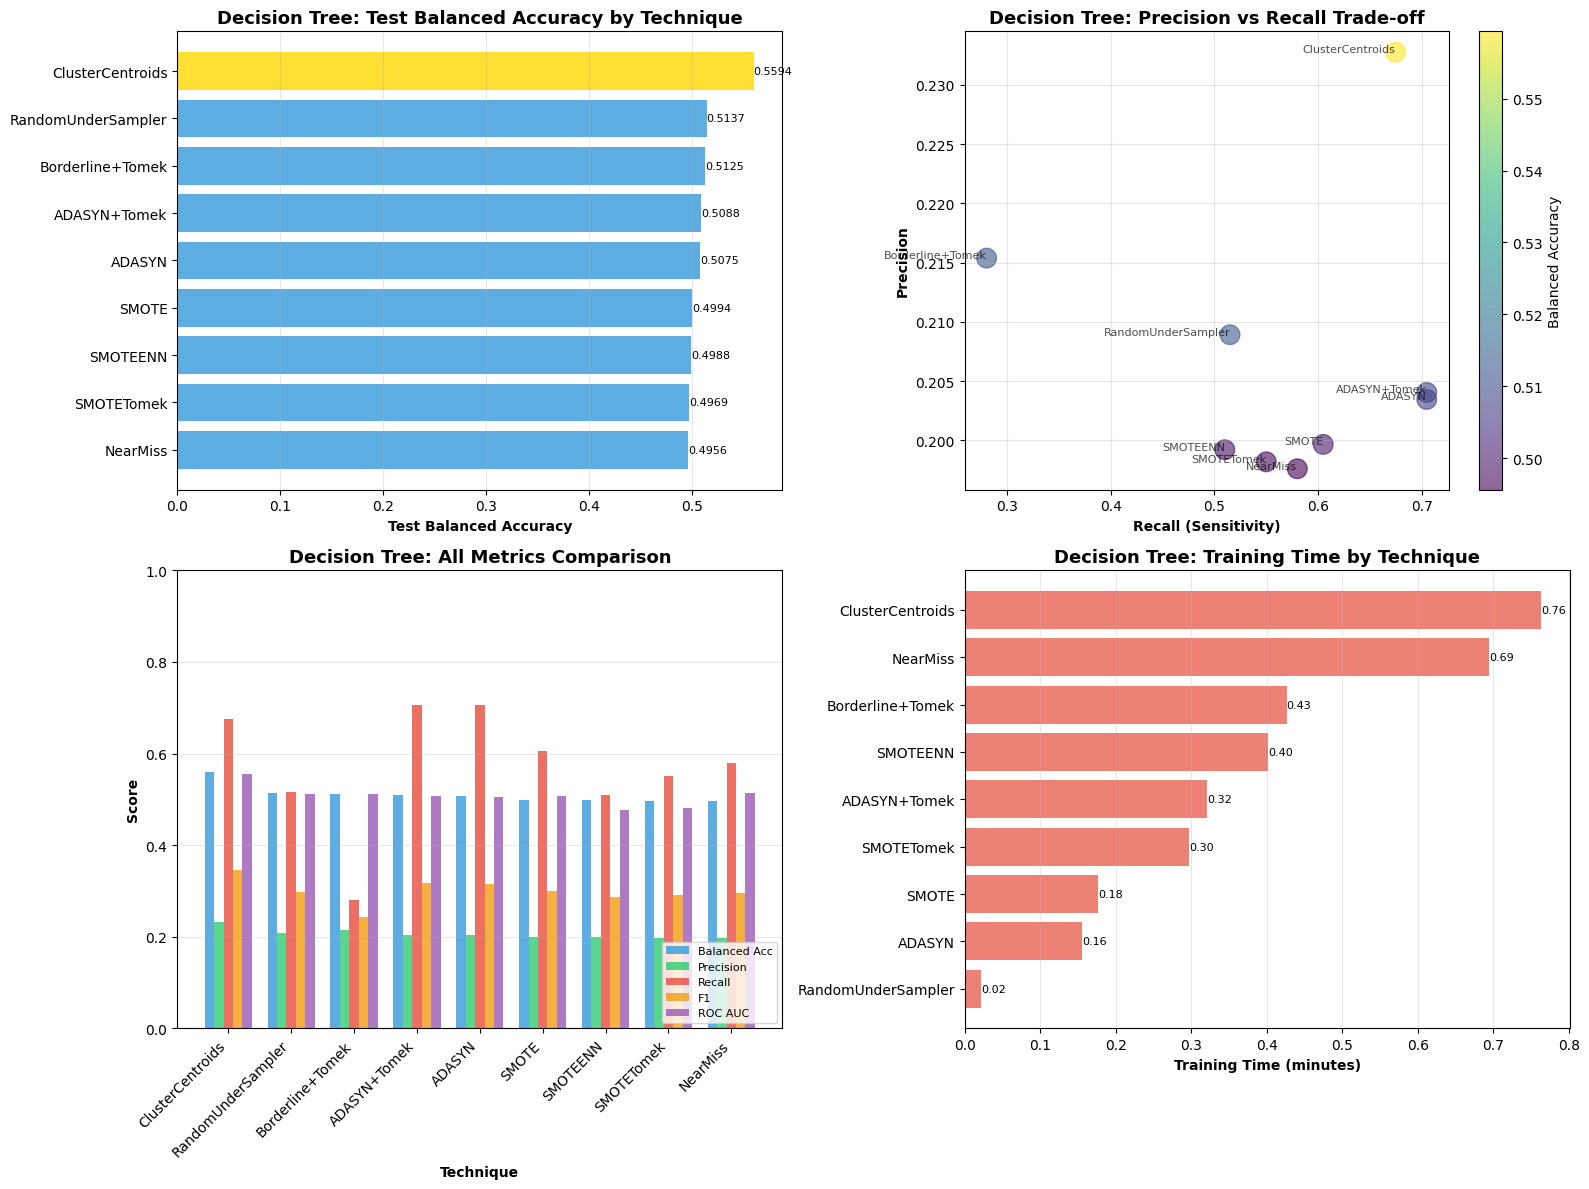

In [32]:
# ==========================================
# 📈 6. Visualize Decision Tree Comparison
# ==========================================

print("\n" + "="*80)
print("📈 Creating Comprehensive Visualizations")
print("="*80)

# Create output directory
output_dir = 'models/decision_tree/comparison_results/'
os.makedirs(output_dir, exist_ok=True)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Balanced Accuracy Comparison
ax1 = axes[0, 0]
comparison_sorted = comparison_df.sort_values('Test_Balanced_Acc')
colors = ['gold' if i == len(comparison_sorted)-1 else '#3498db' for i in range(len(comparison_sorted))]
bars1 = ax1.barh(comparison_sorted['Technique'], comparison_sorted['Test_Balanced_Acc'], color=colors, alpha=0.8)
ax1.set_xlabel('Test Balanced Accuracy', fontweight='bold')
ax1.set_title('Decision Tree: Test Balanced Accuracy by Technique', fontweight='bold', fontsize=13)
ax1.grid(axis='x', alpha=0.3)
# Add value labels
for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontsize=8)

# 2. Precision vs Recall
ax2 = axes[0, 1]
scatter = ax2.scatter(comparison_df['Test_Recall'], comparison_df['Test_Precision'], 
                     s=200, alpha=0.6, c=comparison_df['Test_Balanced_Acc'], cmap='viridis')
for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Technique'].split()[0],  # First word only
                (row['Test_Recall'], row['Test_Precision']),
                fontsize=8, ha='right', alpha=0.7)
ax2.set_xlabel('Recall (Sensitivity)', fontweight='bold')
ax2.set_ylabel('Precision', fontweight='bold')
ax2.set_title('Decision Tree: Precision vs Recall Trade-off', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Balanced Accuracy')

# 3. Multiple Metrics Comparison
ax3 = axes[1, 0]
metrics_to_plot = ['Test_Balanced_Acc', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
x = np.arange(len(comparison_df))
width = 0.15
colors_metrics = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
for i, metric in enumerate(metrics_to_plot):
    ax3.bar(x + i*width, comparison_df[metric], width, 
           label=metric.replace('Test_', '').replace('_', ' '), 
           color=colors_metrics[i], alpha=0.8)
ax3.set_xlabel('Technique', fontweight='bold')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Decision Tree: All Metrics Comparison', fontweight='bold', fontsize=13)
ax3.set_xticks(x + width * 2)
ax3.set_xticklabels([t.split()[0] for t in comparison_df['Technique']], rotation=45, ha='right')
ax3.legend(loc='lower right', fontsize=8)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Training Time
ax4 = axes[1, 1]
comparison_sorted_time = comparison_df.sort_values('Time_Minutes')
bars4 = ax4.barh(comparison_sorted_time['Technique'], comparison_sorted_time['Time_Minutes'], 
                color='#e74c3c', alpha=0.7)
ax4.set_xlabel('Training Time (minutes)', fontweight='bold')
ax4.set_title('Decision Tree: Training Time by Technique', fontweight='bold', fontsize=13)
ax4.grid(axis='x', alpha=0.3)
# Add value labels
for bar in bars4:
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
            ha='left', va='center', fontsize=8)

plt.tight_layout()
viz_path = f'{output_dir}DT_Comprehensive_Comparison.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✅ Comprehensive visualization saved: {viz_path}")
plt.show()



🎨 Creating Additional Visualizations
✅ Additional analysis saved: models/decision_tree/comparison_results/DT_Additional_Analysis.png


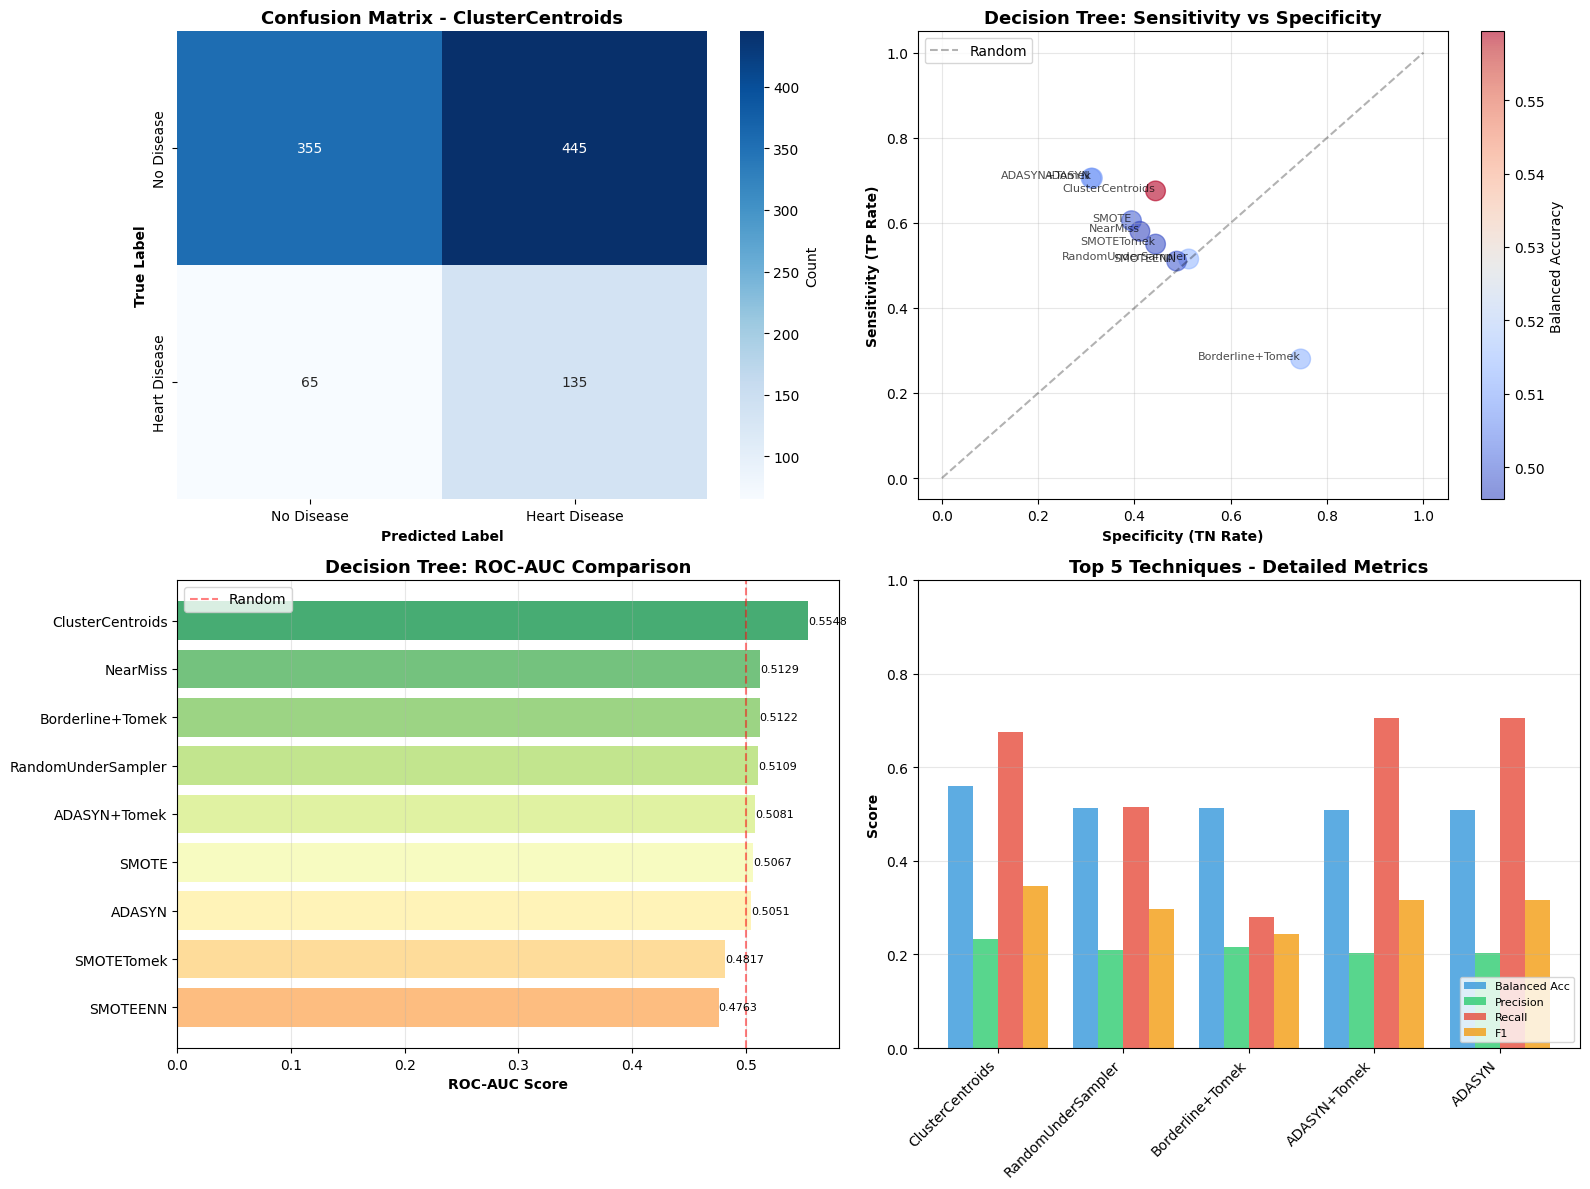

In [33]:
# ==========================================
# 🎨 7. Additional Visualizations
# ==========================================

print("\n" + "="*80)
print("🎨 Creating Additional Visualizations")
print("="*80)

# Create second figure with more detailed plots
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix for Best Technique
ax1 = axes2[0, 0]
best_model = all_models[best_technique['Technique']]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
class_names = ['No Disease', 'Heart Disease']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
ax1.set_title(f'Confusion Matrix - {best_technique["Technique"]}', fontweight='bold', fontsize=13)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# 2. Sensitivity vs Specificity
ax2 = axes2[0, 1]
scatter2 = ax2.scatter(comparison_df['Specificity'], comparison_df['Sensitivity'],
                      s=200, alpha=0.6, c=comparison_df['Test_Balanced_Acc'], cmap='coolwarm')
for idx, row in comparison_df.iterrows():
    ax2.annotate(row['Technique'].split()[0],
                (row['Specificity'], row['Sensitivity']),
                fontsize=8, ha='right', alpha=0.7)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax2.set_xlabel('Specificity (TN Rate)', fontweight='bold')
ax2.set_ylabel('Sensitivity (TP Rate)', fontweight='bold')
ax2.set_title('Decision Tree: Sensitivity vs Specificity', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3)
ax2.legend()
plt.colorbar(scatter2, ax=ax2, label='Balanced Accuracy')

# 3. ROC-AUC Comparison
ax3 = axes2[1, 0]
comparison_sorted_auc = comparison_df.sort_values('Test_ROC_AUC')
colors_auc = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(comparison_sorted_auc)))
bars3 = ax3.barh(comparison_sorted_auc['Technique'], comparison_sorted_auc['Test_ROC_AUC'],
                color=colors_auc, alpha=0.8)
ax3.set_xlabel('ROC-AUC Score', fontweight='bold')
ax3.set_title('Decision Tree: ROC-AUC Comparison', fontweight='bold', fontsize=13)
ax3.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
ax3.grid(axis='x', alpha=0.3)
ax3.legend()
# Add value labels
for bar in bars3:
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontsize=8)

# 4. Top 5 Techniques Summary
ax4 = axes2[1, 1]
top_5 = comparison_df.head(5)
metrics_top5 = ['Test_Balanced_Acc', 'Test_Precision', 'Test_Recall', 'Test_F1']
x_top5 = np.arange(len(top_5))
width_top5 = 0.2
colors_top5 = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for i, metric in enumerate(metrics_top5):
    ax4.bar(x_top5 + i*width_top5, top_5[metric], width_top5, 
           label=metric.replace('Test_', '').replace('_', ' '),
           color=colors_top5[i], alpha=0.8)
ax4.set_ylabel('Score', fontweight='bold')
ax4.set_title('Top 5 Techniques - Detailed Metrics', fontweight='bold', fontsize=13)
ax4.set_xticks(x_top5 + width_top5 * 1.5)
ax4.set_xticklabels([t.split()[0] for t in top_5['Technique']], rotation=45, ha='right')
ax4.legend(loc='lower right', fontsize=8)
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
viz_path2 = f'{output_dir}DT_Additional_Analysis.png'
plt.savefig(viz_path2, dpi=300, bbox_inches='tight')
print(f"✅ Additional analysis saved: {viz_path2}")
plt.show()


In [34]:
# ==========================================
# 💾 8. Save All Results
# ==========================================

print("\n" + "="*80)
print("💾 Saving All Results and Best Model")
print("="*80)

best_model = all_models[best_technique['Technique']]

# Save comparison table
comparison_csv_path = f'{output_dir}DT_Comparison_Results.csv'
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"✅ Comparison table saved: {comparison_csv_path}")

# Save best model
model_path = f'{output_dir}DT_Best_{best_technique["Technique"].replace(" ", "_")}.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Best model saved: {model_path}")

# Save comprehensive summary
summary = {
    'best_technique': best_technique['Technique'],
    'metrics': {
        'cv_balanced_accuracy': float(best_technique['CV_Balanced_Acc']),
        'test_balanced_accuracy': float(best_technique['Test_Balanced_Acc']),
        'test_accuracy': float(best_technique['Test_Accuracy']),
        'test_precision': float(best_technique['Test_Precision']),
        'test_recall': float(best_technique['Test_Recall']),
        'test_f1_score': float(best_technique['Test_F1']),
        'test_roc_auc': float(best_technique['Test_ROC_AUC']),
        'specificity': float(best_technique['Specificity']),
        'sensitivity': float(best_technique['Sensitivity'])
    },
    'training_info': {
        'training_time_minutes': float(best_technique['Time_Minutes']),
        'cv_folds': 5,
        'total_techniques_tested': len(all_results),
        'n_iter_per_technique': 30
    },
    'all_techniques_ranking': [
        {
            'rank': i+1,
            'technique': row['Technique'],
            'test_balanced_accuracy': float(row['Test_Balanced_Acc']),
            'test_roc_auc': float(row['Test_ROC_AUC'])
        }
        for i, (_, row) in enumerate(comparison_df.iterrows())
    ]
}

summary_path = f'{output_dir}DT_Complete_Summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)
print(f"✅ Complete summary saved: {summary_path}")

print("\n" + "="*80)
print("✅ ALL DONE!")
print("="*80)
print(f"\n📊 Summary:")
print(f"   Total Techniques Tested:  {len(all_results)}")
print(f"   Best Technique:           {best_technique['Technique']}")
print(f"   Best Balanced Accuracy:   {best_technique['Test_Balanced_Acc']:.4f}")
print(f"   Best ROC-AUC:             {best_technique['Test_ROC_AUC']:.4f}")
print(f"   Total Training Time:      {comparison_df['Time_Minutes'].sum():.2f} minutes")
print(f"\n📁 All results saved in:    {output_dir}")
print("="*80)



💾 Saving All Results and Best Model
✅ Comparison table saved: models/decision_tree/comparison_results/DT_Comparison_Results.csv
✅ Best model saved: models/decision_tree/comparison_results/DT_Best_ClusterCentroids.pkl
✅ Complete summary saved: models/decision_tree/comparison_results/DT_Complete_Summary.json

✅ ALL DONE!

📊 Summary:
   Total Techniques Tested:  9
   Best Technique:           ClusterCentroids
   Best Balanced Accuracy:   0.5594
   Best ROC-AUC:             0.5548
   Total Training Time:      3.26 minutes

📁 All results saved in:    models/decision_tree/comparison_results/
